# Protein Language Model Intro

Many are familar with transformer models and LLMs etc etc. And many have heard about Alphafold2 and the application of ML in protein design. However, the recent developments in the field are much more exciting than even that. 

Protein Language Models are transformer based models, that have been trained on protein sequence data using deep learning methods. The training methods vary, however, fundamentally, the models are meant to learn the underlying biological and physical structures and mechanism that determine protein sequences. 

Protein sequences, a string of captial letters, corresponding to different amino acids, determine the physical makeup of protein, which determines their function. Protein are fundamental to life, and being able to design proteins 'de novo' opens up so many possibilities. 

Trying to learn the syntax of biology is increadibly difficult, as it is very complex, however, pLMs, as they are known, are our best attempt so far and they enable so much more than was possible before. 

Computational protein structure experienced a breakthrough with the introduction of Alphafold2, that was able to predict strucuture with higher than ever accuracies. But, it still relied of multiple sequence alignment, and was only useful for structure prediction. 

However, not much later, ESM, and ProtT5 and others came into the picture. These are models trained only on sequence data, and they encode the amino acid sequence into a higher dimension. These embeddings, although difficult to understand, are increadibly information rich, and can actually be used to create structure predictions with a downstream model. This proved to be more effective than even alphafold2. 

This notebook with use these two models to generate some embeddings for a selection of protein, and then will compare the embeddings between the two models, to see if the different architectures and model training regimes result in a different 'understanding' of the sequence data. 

# Protein Embedding Generation with T5 and ESM-650M

First we need to load the T5 and ESM-650M models from Hugging Face Transformers.

In [2]:
from transformers import T5Tokenizer, T5EncoderModel, AutoTokenizer, AutoModel
import torch

# Load T5 model and tokenizer (ProtT5-XL-UniRef50)
t5_tokenizer = T5Tokenizer.from_pretrained('Rostlab/prot_t5_xl_half_uniref50-enc', local_files_only=True, revision='94a6abc', lowercase=False)
t5_model = T5EncoderModel.from_pretrained('Rostlab/prot_t5_xl_half_uniref50-enc', local_files_only=True, revision='94a6abc', device_map=None).cpu()

t5_model.eval()

# Load ESM-650M model and tokenizer
esm_tokenizer = AutoTokenizer.from_pretrained('facebook/esm2_t36_3B_UR50D', local_files_only=True)
esm_model = AutoModel.from_pretrained('facebook/esm2_t36_3B_UR50D', local_files_only=True, device_map=None).cpu()

esm_model.eval()

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EsmModel(
  (embeddings): EsmEmbeddings(
    (word_embeddings): Embedding(33, 2560, padding_idx=1)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): EsmEncoder(
    (layer): ModuleList(
      (0-35): 36 x EsmLayer(
        (attention): EsmAttention(
          (self): EsmSelfAttention(
            (query): Linear(in_features=2560, out_features=2560, bias=True)
            (key): Linear(in_features=2560, out_features=2560, bias=True)
            (value): Linear(in_features=2560, out_features=2560, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (rotary_embeddings): RotaryEmbedding()
          )
          (output): EsmSelfOutput(
            (dense): Linear(in_features=2560, out_features=2560, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (LayerNorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        )
        (intermediate): EsmIntermediate(
          (dense): Linear(in_features=2560, out_feature

Lets download some freely accessible protein sequences, and select a few. 

In [2]:
# !curl -o Uniref50.fasta https://ftp.uniprot.org/pub/databases/uniprot/uniref/uniref50/uniref50.fasta.gz

# this is quite a large file, so I downloaded it separately
# generated a subset
# and placed it in this directory

And now lets make a quick function that will read this fasta file

In [3]:
def read_fasta_with_names(filepath):
    names = []
    seqs = []
    with open(filepath, 'r') as f:
        seq = ''
        name = None
        for line in f:
            if line.startswith('>'):
                if seq and name:
                    names.append(name)
                    seqs.append(seq)
                    seq = ''
                name = line[1:].strip().replace(' ', '_')
            else:
                seq += line.strip()
        if seq and name:
            names.append(name)
            seqs.append(seq)
    return names, seqs


In [4]:
# Replace 'P62593.fasta' with your file path
names, seqs = read_fasta_with_names('selected_proteins.fasta')
print(f"Loaded {len(seqs)} protein sequences.")

Loaded 100 protein sequences.


## Generate and Save Embeddings for the First 10 Protein Sequences

The following cells generate embeddings for the first 10 loaded protein sequences using T5 and ESM-650M, and save the results in the respective output folders.

In [5]:
import re
from tqdm import tqdm
import os
import numpy as np

def generate_embeddings(model, tokenizer, seqs, names, output_dir, model_type='t5', mean_pool=True, special_tokens=True, rare_aa_replace=True):
    """
    Generate and save embeddings for protein sequences with sorting, rare AA handling, attention masking, and mean pooling.
    For ESM models, also saves the CLS embedding.
    Args:
        model: HuggingFace model
        tokenizer: HuggingFace tokenizer
        seqs: list of protein sequences
        names: list of sequence names (same order as seqs)
        output_dir: directory to save embeddings
        model_type: 't5' or 'esm' (for preprocessing)
        mean_pool: if True, mean-pool over sequence length
        special_tokens: if True, add special tokens
        rare_aa_replace: if True, replace U/Z/O/B with X
    """
    os.makedirs(output_dir, exist_ok=True)
    # Sort by sequence length (descending)
    seq_tuples = sorted(zip(names, seqs), key=lambda x: len(x[1]), reverse=True)
    for name, seq in tqdm(seq_tuples, desc=f"Generating embeddings for {model_type}"):
        # Replace rare/ambiguous amino acids
        if rare_aa_replace:
            seq = re.sub(r"[UZOB]", "X", seq)
        # T5 expects spaces between amino acids
        if model_type == 't5':
            seq_proc = ' '.join(list(seq))
        else:
            seq_proc = seq
        # Tokenize
        tokens = tokenizer(
            seq_proc,
            add_special_tokens=special_tokens,
            return_tensors='pt',
            padding=False,
            truncation=False
        )
        input_ids = tokens['input_ids']
        attention_mask = tokens['attention_mask'] if 'attention_mask' in tokens else None
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask) if attention_mask is not None else model(input_ids=input_ids)
            emb = outputs.last_hidden_state.squeeze(0)  # [seq_len, hidden_dim]
            if model_type == 'esm':
                # Save CLS embedding (first token)
                cls_emb = emb[0].cpu().numpy()
                np.save(os.path.join(output_dir, f"{name}_CLS_embedding.npy"), cls_emb)
            if mean_pool:
                if attention_mask is not None:
                    mask = attention_mask.squeeze(0).unsqueeze(-1).expand(emb.size()).float()
                    summed = (emb * mask).sum(0)
                    count = mask.sum(0).clamp(min=1e-9)
                    emb_vec = (summed / count).cpu().numpy()
                else:
                    emb_vec = emb.mean(dim=0).cpu().numpy()
                np.save(os.path.join(output_dir, f"{name}_embedding.npy"), emb_vec)
            else:
                np.save(os.path.join(output_dir, f"{name}_embedding.npy"), emb.cpu().numpy())
    print(f"All embeddings saved to {output_dir}")


Generate the actual embeddings

In [6]:

# T5
generate_embeddings(
    model=t5_model,
    tokenizer=t5_tokenizer,
    seqs=seqs,
    names=names,
    output_dir='output/protT5/',
    model_type='t5',
    mean_pool=True
)

# ESM
generate_embeddings(
    model=esm_model,
    tokenizer=esm_tokenizer,
    seqs=seqs,
    names=names,
    output_dir='output/ESM/',
    model_type='esm',
    mean_pool=True
)


Generating embeddings for t5: 100%|██████████| 100/100 [01:13<00:00,  1.35it/s]


All embeddings saved to output/protT5/


Generating embeddings for esm: 100%|██████████| 100/100 [1:08:34<00:00, 41.15s/it]

All embeddings saved to output/ESM/


# UMAP Dimensionality Reduction and Clustering of Protein Embeddings

Now lets take our ESM (mean pooled and CLS) and ProtT5 (only mean pooled as there is no CLS token) embeddings, detect clusters, and perform a UMAP, t-SNE & PCA dimensionality reduction. Hopefully, we will be able to visualize the clusters being slightly different between ESM and ProtT5. Cluster colors are assigned by protein name and are based off DBSCAN clustering the ESM mean pooled embeddings.


In [5]:
import os
import umap
import numpy as np
import pandas as pd
import plotly.colors
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN


def load_embeddings_from_folder(folder, suffix="_embedding.npy"):
    """
    Loads embeddings from a folder. Returns:
    - names: list of protein names (from file names)
    - embeddings: list of numpy arrays
    """
    files = sorted([f for f in os.listdir(folder) if f.endswith(suffix) and not f.endswith(f"_CLS{suffix}")])
    names = [f.replace(suffix, "") for f in files]
    embeddings = [np.load(os.path.join(folder, f)) for f in files]
    return names, np.vstack(embeddings)

def load_cls_embeddings_from_folder(folder, suffix="_CLS_embedding.npy"):
    """
    Loads CLS embeddings from a folder. Returns:
    - names: list of protein names (from file names)
    - embeddings: list of numpy arrays
    """
    files = sorted([f for f in os.listdir(folder) if f.endswith(suffix)])
    names = [f.replace(suffix, "") for f in files]
    embeddings = [np.load(os.path.join(folder, f)) for f in files]
    return names, np.vstack(embeddings)

# --- Utility Functions ---
def run_umap(embeddings, n_neighbors=10, min_dist=0.3, n_components=2, random_state=42):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=random_state)
    embedding_2d = reducer.fit_transform(embeddings)
    return embedding_2d

def run_tsne(embeddings, n_components=2, random_state=42):
    tsne = TSNE(n_components=n_components, random_state=random_state, init='pca')
    embedding_2d = tsne.fit_transform(embeddings)
    return embedding_2d

def run_pca(embeddings, n_components=2, random_state=42):
    pca = PCA(n_components=n_components, random_state=random_state)
    embedding_2d = pca.fit_transform(embeddings)
    return embedding_2d

def detect_clusters(embedding_2d, names, eps=1.0, min_samples=3):
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(embedding_2d)
    labels = clustering.labels_
    name_to_cluster = {name: label for name, label in zip(names, labels)}
    return name_to_cluster

def assign_colors_by_cluster(name_to_cluster):
    unique_labels = sorted(set(name_to_cluster.values()))
    color_palette = plotly.colors.qualitative.Plotly
    color_map = {label: color_palette[i % len(color_palette)] for i, label in enumerate(unique_labels)}
    name_to_color = {name: color_map[cluster] for name, cluster in name_to_cluster.items()}
    return name_to_color

def make_df(embedding_2d, names, name_to_color):
    return pd.DataFrame({
        'x': embedding_2d[:, 0],
        'y': embedding_2d[:, 1],
        'name': names,
        'color': [name_to_color.get(name, 'gray') for name in names]
    })


First, let us load all of the embeddings.


In [6]:
esm_folder = "output/ESM"
protT5_folder = "output/protT5"

esm_names, esm_embeddings = load_embeddings_from_folder(esm_folder, suffix="_embedding.npy")
esm_cls_names, esm_cls_embeddings = load_cls_embeddings_from_folder(esm_folder, suffix="_CLS_embedding.npy")
protT5_names, protT5_embeddings = load_embeddings_from_folder(protT5_folder, suffix="_embedding.npy")

Let us generate clusters on our embeddings to color groupings of embeddings a specific color. Here it is done based off the ESM mean pooling embeddings, and those colors are kept constant throughout the notebook.

In [7]:
# Cluster on ESM mean pooled embeddings
esm_name_to_cluster = detect_clusters(esm_embeddings, esm_names, eps=2.3, min_samples=10)
esm_name_to_color = assign_colors_by_cluster(esm_name_to_cluster)

Let us generate the data we want to plot aka 
- UMAP
- t-SNE
- PCA
using different seeds for the 3 methods (so 9 sets of results)

In [8]:
# --- Prepare DataFrames for All Reductions and Seeds ---
random_seeds = [42, 54643, 23456342]

# For each seed, store a dict of {method: (df, title)}
all_rows = []
for seed in random_seeds:
    # UMAP
    esm_umap = run_umap(esm_embeddings, random_state=seed)
    esm_cls_umap = run_umap(esm_cls_embeddings, random_state=seed)
    protT5_umap = run_umap(protT5_embeddings, random_state=seed)
    # t-SNE
    esm_tsne = run_tsne(esm_embeddings, random_state=seed)
    esm_cls_tsne = run_tsne(esm_cls_embeddings, random_state=seed)
    protT5_tsne = run_tsne(protT5_embeddings, random_state=seed)
    # PCA
    esm_pca = run_pca(esm_embeddings, random_state=seed)
    esm_cls_pca = run_pca(esm_cls_embeddings, random_state=seed)
    protT5_pca = run_pca(protT5_embeddings, random_state=seed)
    # DataFrames (all colored by ESM mean pool clustering)
    row = {
        'UMAP': [
            make_df(esm_umap, esm_names, esm_name_to_color),
            make_df(esm_cls_umap, esm_cls_names, esm_name_to_color),
            make_df(protT5_umap, protT5_names, esm_name_to_color)
        ],
        't-SNE': [
            make_df(esm_tsne, esm_names, esm_name_to_color),
            make_df(esm_cls_tsne, esm_cls_names, esm_name_to_color),
            make_df(protT5_tsne, protT5_names, esm_name_to_color)
        ],
        'PCA': [
            make_df(esm_pca, esm_names, esm_name_to_color),
            make_df(esm_cls_pca, esm_cls_names, esm_name_to_color),
            make_df(protT5_pca, protT5_names, esm_name_to_color)
        ]
    }
    all_rows.append(row)

/Users/ignacybartnik/Documents/pLM_Embeddings_Comparison/embeddings_comp/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ignacybartnik/Documents/pLM_Embeddings_Comparison/embeddings_comp/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/ignacybartnik/Documents/pLM_Embeddings_Comparison/embeddings_comp/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ignacybartnik/Documents/pLM_Embeddings_Comparison/embeddings_comp/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden 

Now, let me plot these dimentional reductions

In [13]:
import matplotlib.pyplot as plt

def plot_embedding_grid_by_method(all_rows, method="UMAP", figsize=(18, 12), random_seeds=None):
    """
    Plots a 3x3 grid of embeddings for a given method.
    - all_rows: list of dicts, each with keys 'UMAP', 't-SNE', 'PCA', each value is a list of 3 DataFrames
    - method: which dimensionality reduction to plot ('UMAP', 't-SNE', 'PCA')
    - random_seeds: list of seeds used for each row (optional, for subtitles)
    """
    n_rows = len(all_rows)
    n_cols = 3
    col_titles = ["ESM Mean Pooled", "ESM CLS", "ProtT5"]
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_rows == 1:
        axes = axes.reshape(1, n_cols)
    for row_idx, row in enumerate(all_rows):
        for col_idx in range(n_cols):
            df = row[method][col_idx]
            ax = axes[row_idx, col_idx]
            sc = ax.scatter(df['x'], df['y'], c=df['color'], s=30, alpha=0.8)
            # Title with column (move up to avoid overlap with subtitle)
            if row_idx == 0:
                ax.set_title(col_titles[col_idx], pad=30)
            # Subtitle with random seed
            if random_seeds is not None:
                ax.text(0.5, 1.08, f"Seed: {random_seeds[row_idx]}", ha='center', va='bottom', transform=ax.transAxes, fontsize=10)
            else:
                ax.text(0.5, 1.08, f"Seed: {row_idx+1}", ha='center', va='bottom', transform=ax.transAxes, fontsize=10)
            # Y label
            if col_idx == 0:
                ax.set_ylabel(f"Seed {row_idx+1}")
            # Axis labels
            ax.set_xlabel(f"{method} 1")
            ax.set_ylabel(f"{method} 2")
            ax.set_xticks([])
            ax.set_yticks([])
    plt.tight_layout()
    plt.show()

## UMAP Plots

UMAP (Uniform Manifold Approximation and Projection) is a dimensionality reduction technique that preserves both local and global structure in high-dimensional data, making it especially useful for visualizing complex datasets. It is widely used in bioinformatics and machine learning to project embeddings into two or three dimensions for cluster analysis and visualization.

When visualizing the ESM mean pooled embeddings, two main clusters are apparent, suggesting some underlying separation in the protein representations. In contrast, the ESM CLS embeddings hint at three groupings, while the ProtT5 embeddings display not much clustering at all. 

However, using the UniRef50 dataset for clustering was not ideal; I had to increase the DBSCAN distance parameter significantly to detect any clusters at all. 

This is expected, as UniRef50 is constructed by clustering UniRef90 seed sequences that share at least 50% sequence identity and 80% overlap with the longest sequence in the cluster, resulting in a dataset composed mostly of unique proteins. Consequently, strong cluster characteristics are not prominent in this dataset.


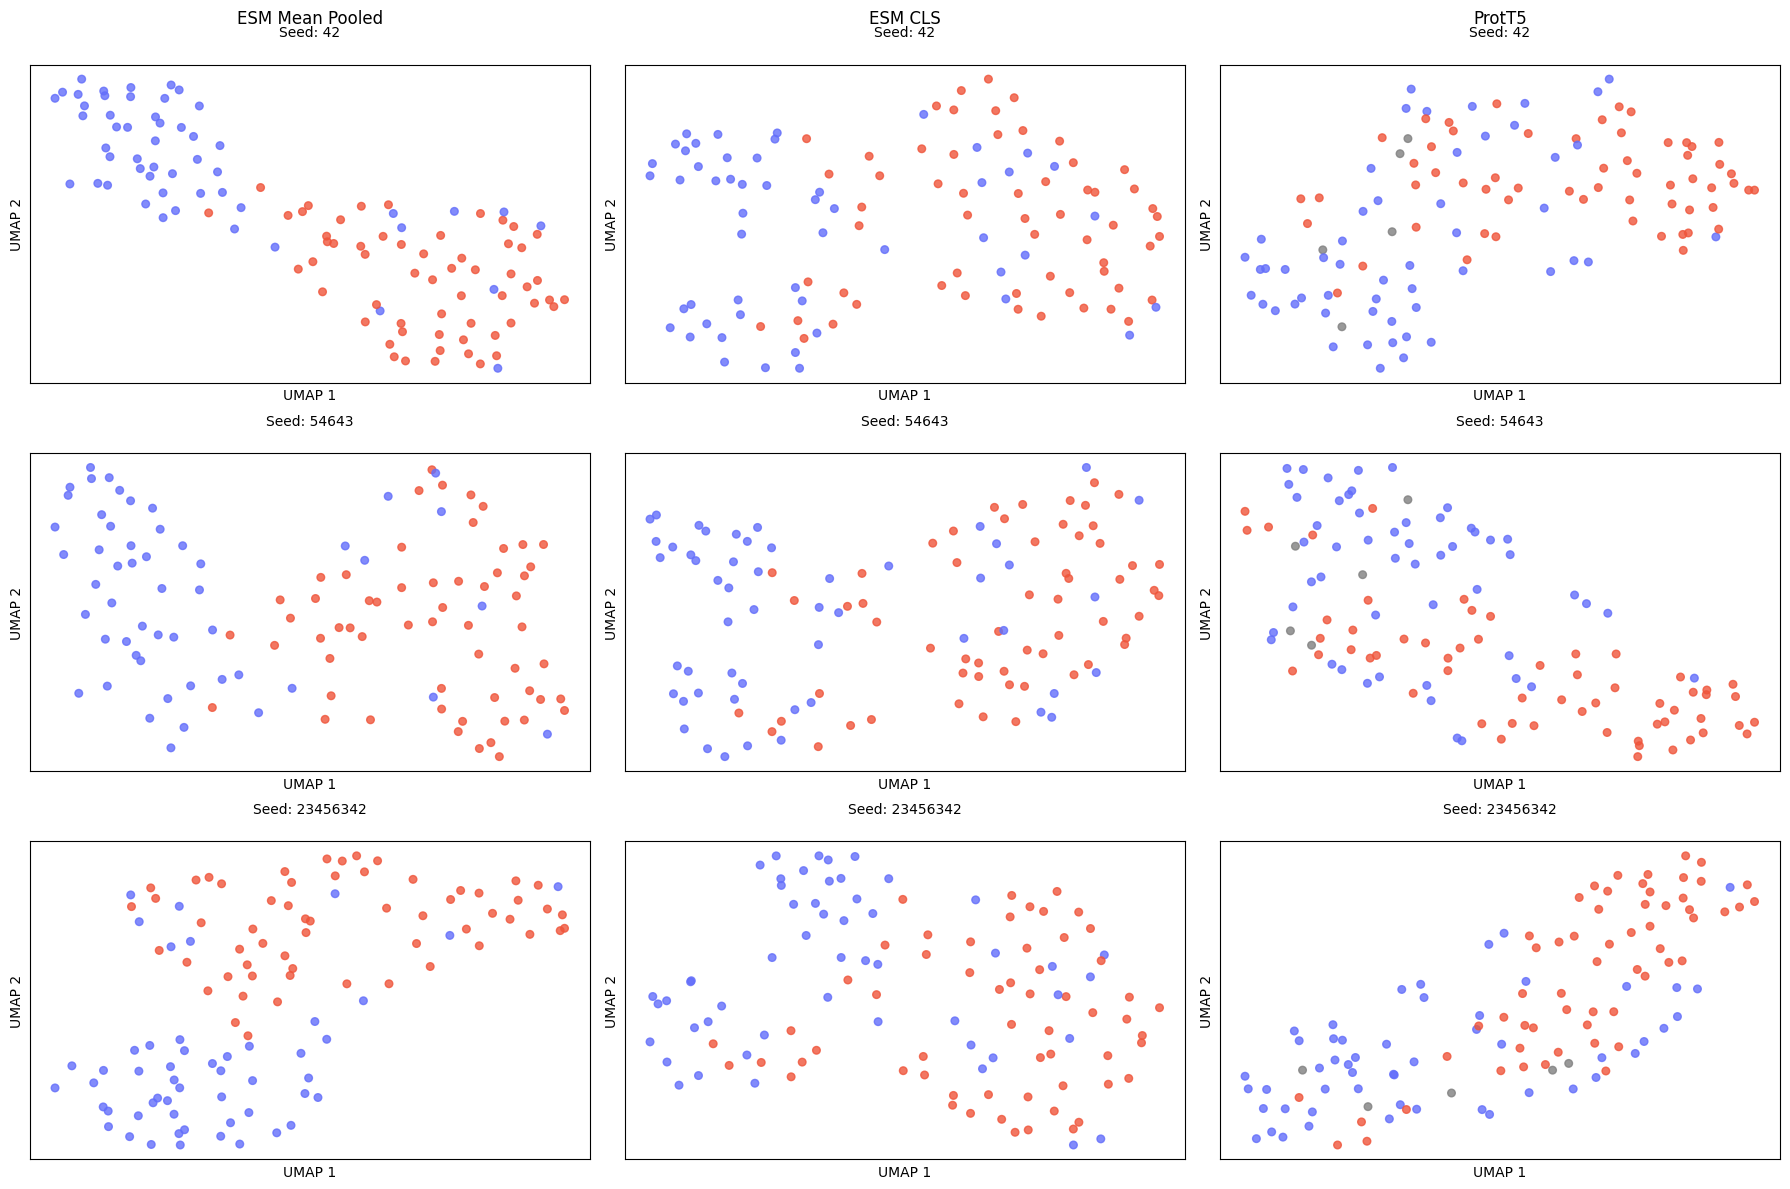

In [14]:
plot_embedding_grid_by_method(all_rows, method="UMAP", random_seeds=random_seeds)


## t-SNE Plots

t-SNE (t-distributed Stochastic Neighbor Embedding) is a nonlinear dimensionality reduction technique that is particularly effective for visualizing high-dimensional data by preserving local structure and revealing clusters in two or three dimensions.

As expected, it gives a similar result to UMAP.

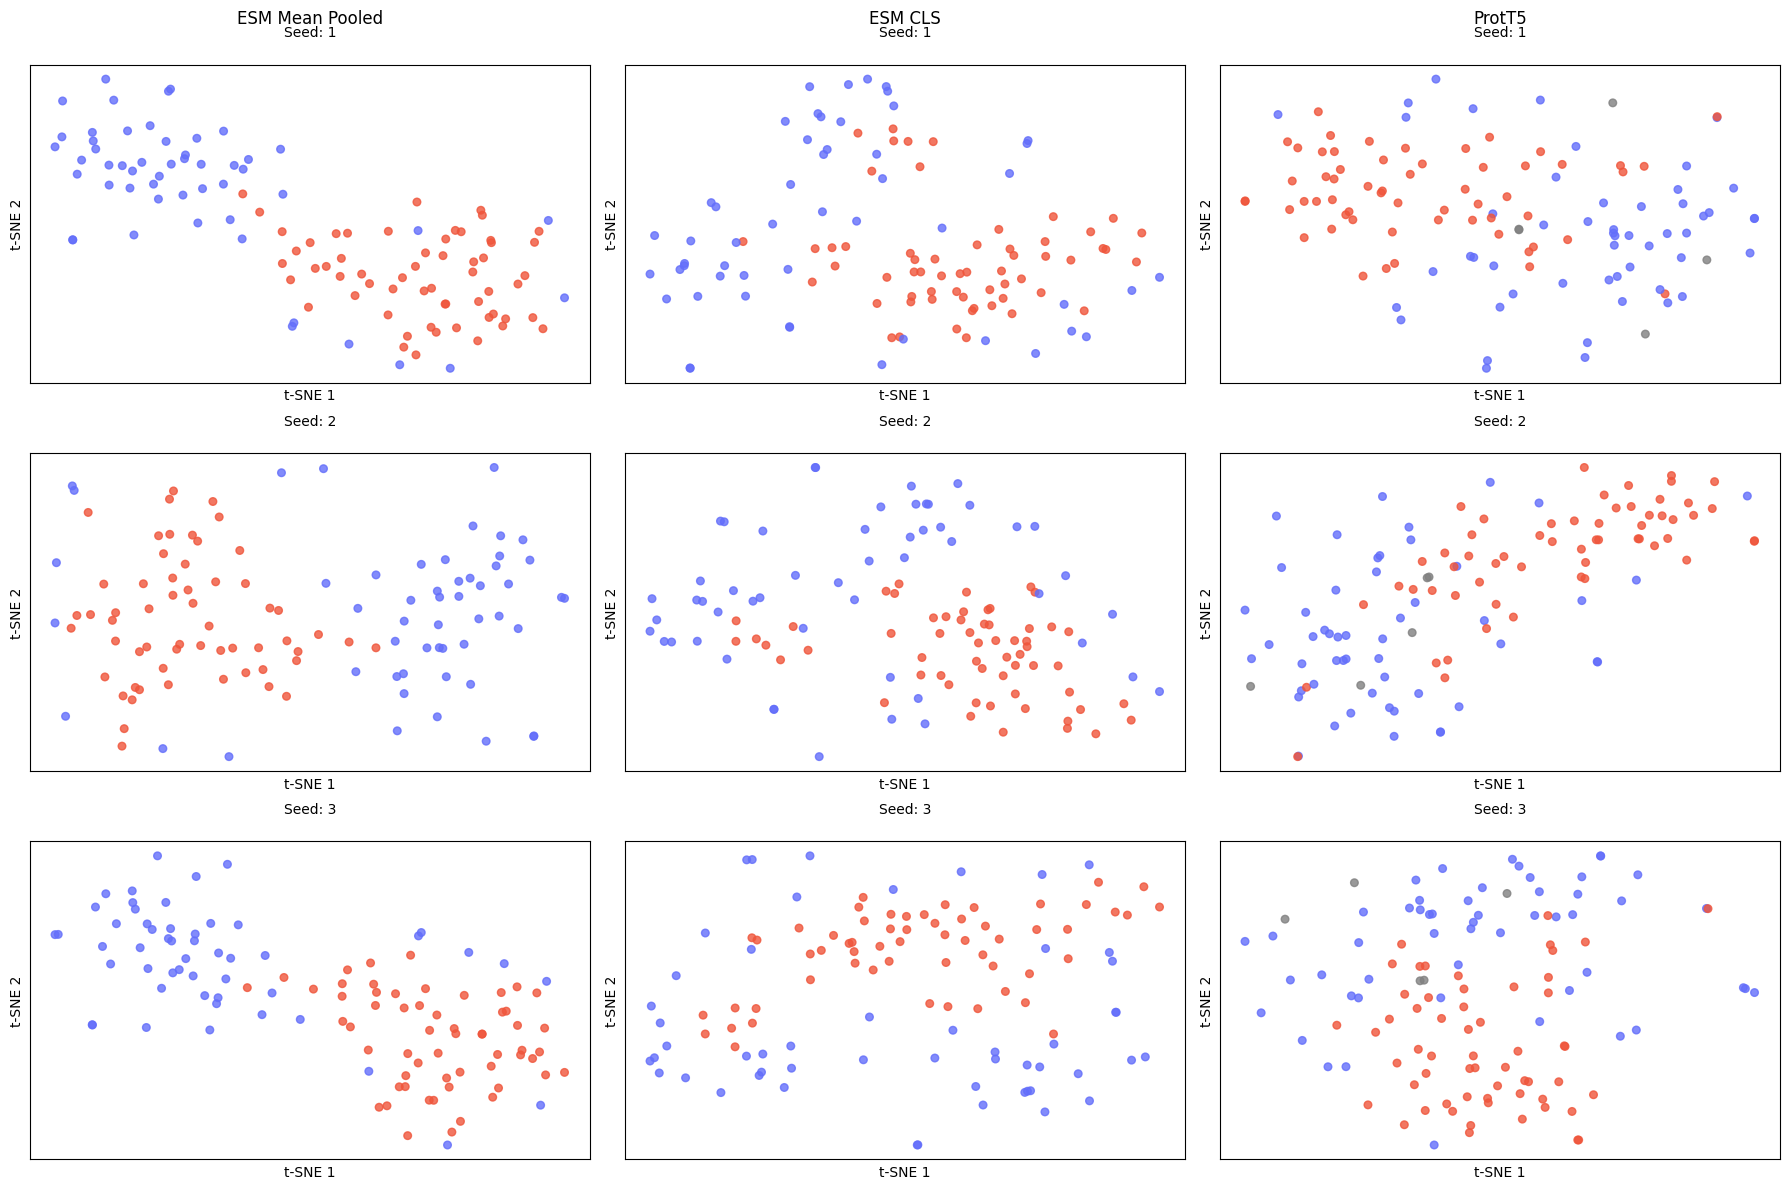

In [15]:
plot_embedding_grid_by_method(all_rows, method="t-SNE")


## PCA Plots

PCA (Principal Component Analysis) is a simpler, linear dimensionality reduction technique that projects the data onto axes (principal components) of maximal variance, capturing the most important patterns in the data. 

Accordingly, PCA does not preserve local groupings as effectively as UMAP or t-SNE, but it does highlight differences in the embeddings: ESM can be meaningfully reduced to two dimensions, while ProtT5 embeddings are mostly captured by a single principal component.

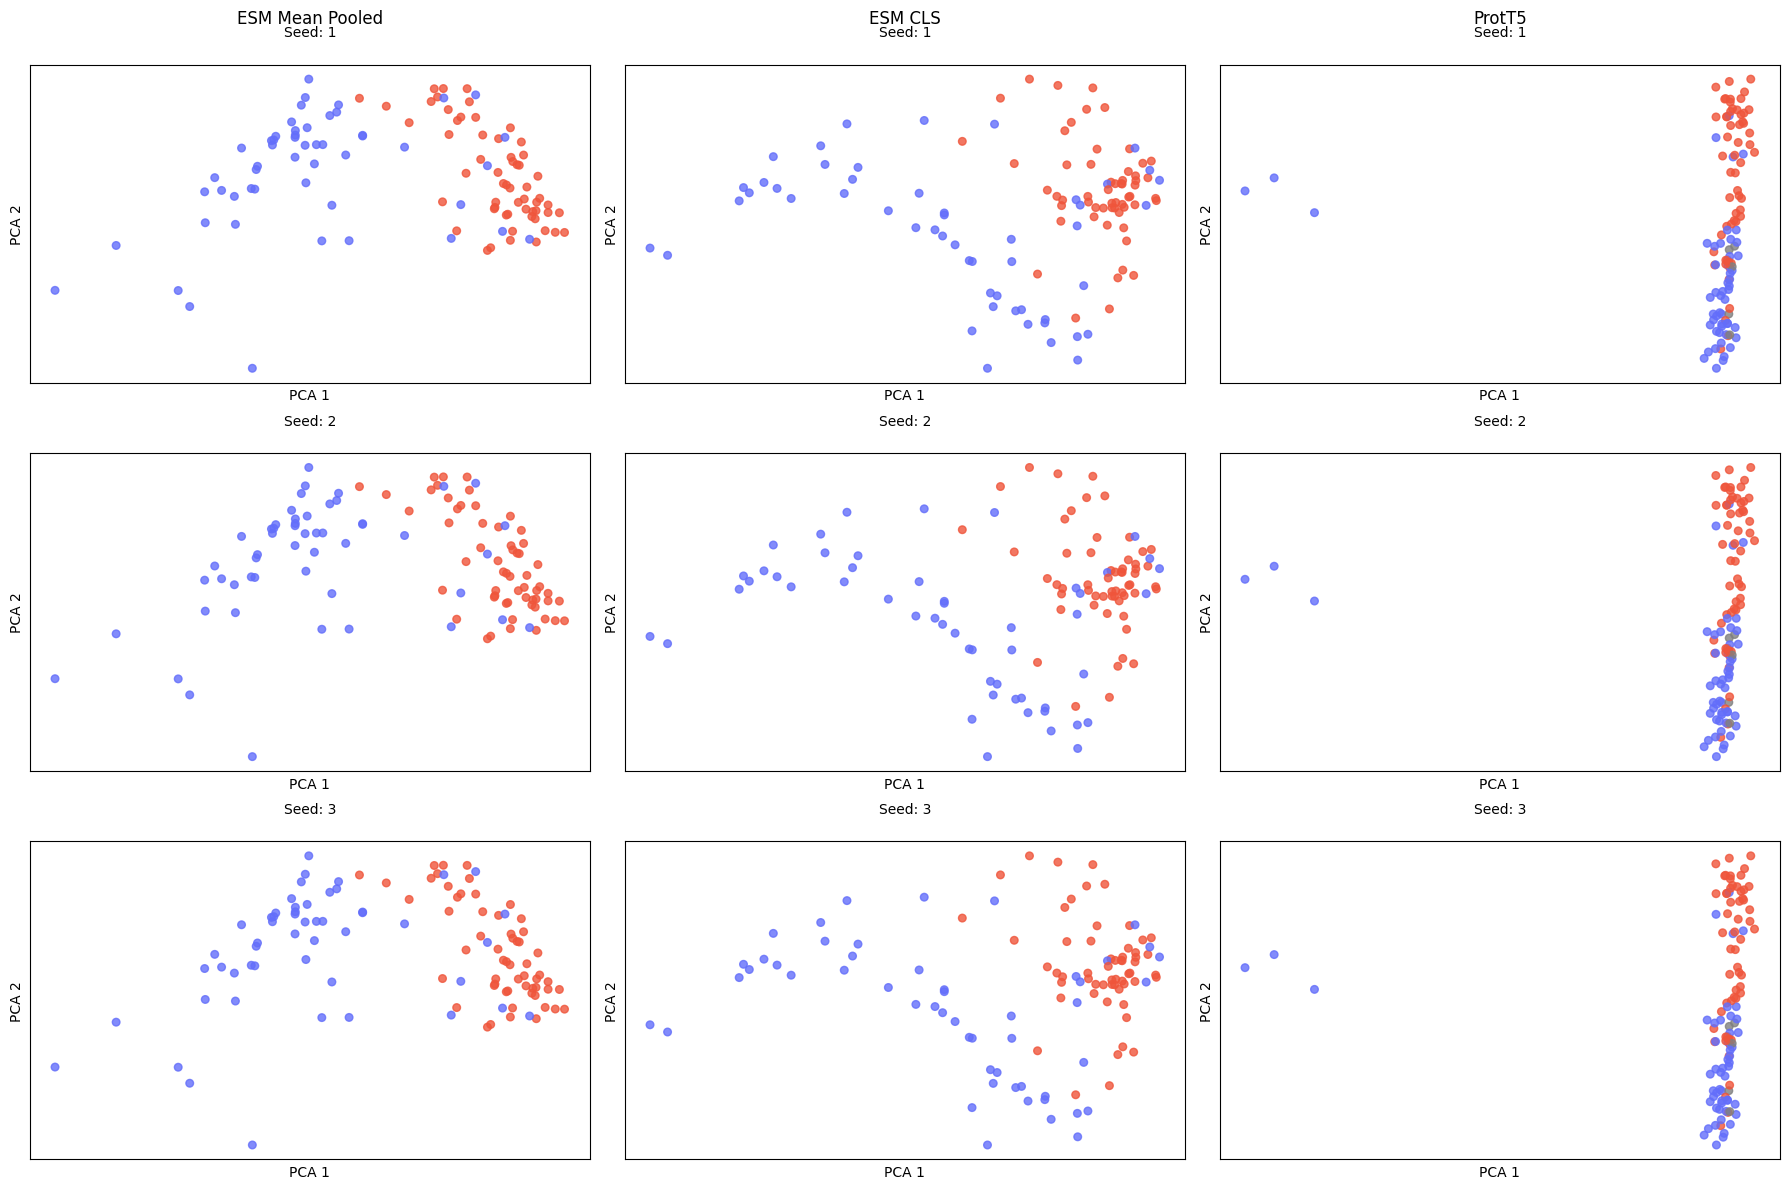

In [16]:
plot_embedding_grid_by_method(all_rows, method="PCA")